In [1]:
import sys
sys.path.insert(0, "..")

In [2]:
import relabel

In [3]:
import numpy as np
import zarr
import dask.array as da
import matplotlib.pyplot as plt

In [4]:
from dask.diagnostics import ProgressBar

In [5]:
from skimage.data import cells3d
from skimage import color

In [11]:
from stardist.models import StarDist2D
from csbdeep.utils import normalize

2024-03-12 14:03:25.222193: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 14:03:25.223526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 14:03:25.403080: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 14:03:25.725541: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Use the 3D Cells example from scikit-image

In [7]:
img = cells3d()[30, 1, :, :]

In [8]:
img.shape

(256, 256)

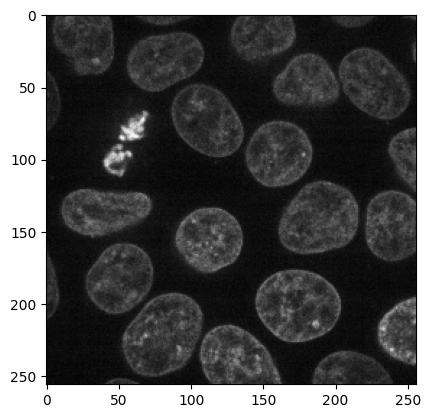

In [10]:
plt.imshow(img, cmap="gray")

## Load the Stardist model

In [12]:
model = StarDist2D.from_pretrained("2D_paper_dsb2018")

def stardist2d(im_chunk, model=None):
    labeled_image, _ = model.predict_instances(normalize(im_chunk, 1,99.8, axis=(0, 1)))
    labeled_image = labeled_image.astype(dtype=np.int32)
    return labeled_image

Found model '2D_paper_dsb2018' for 'StarDist2D'.
5231396/5231396 [==============================] - 0s 0us/step


2024-03-12 14:03:57.746107: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31127 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0


Loading network weights from 'weights_last.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.417819, nms_thresh=0.5.


In [28]:
%%time
labels_ref = stardist2d(img, model=model)

CPU times: user 699 ms, sys: 4.53 ms, total: 703 ms
Wall time: 513 ms


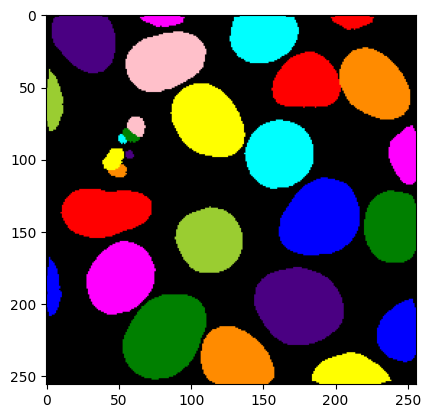

In [29]:
plt.imshow(color.label2rgb(labels_ref))

## Execute the segmentation and relabeling process

In [18]:
img_da = da.from_array(img, chunks=(128, 128))
img_da

dask.array<array, shape=(256, 256), dtype=uint16, chunksize=(128, 128), chunktype=numpy.ndarray>

In [20]:
%%time
labels = relabel.image2labels(
    img_da,
    seg_fn=stardist2d,
    overlaps=[64, 64],
    ndim=2,
    segmentation_fn_kwargs={"model": model}
)

CPU times: user 164 ms, sys: 9.33 ms, total: 173 ms
Wall time: 168 ms


In [21]:
labels

dask.array<_trim, shape=(256, 256), dtype=int64, chunksize=(128, 128), chunktype=numpy.ndarray>

In [22]:
%%time
with ProgressBar():
    labels = labels.compute()

[########################################] | 100% Completed | 1.62 sms
CPU times: user 2.51 s, sys: 71.7 ms, total: 2.58 s
Wall time: 1.77 s


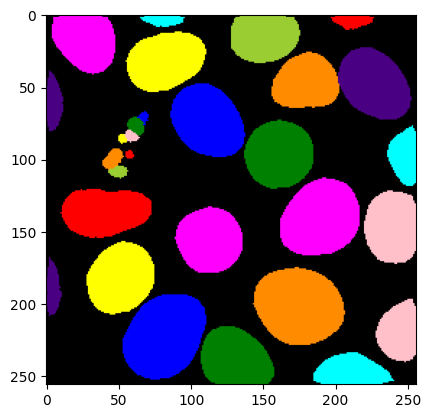

In [24]:
plt.subplot(1, 2, 1)
plt.
plt.imshow(color.label2rgb(labels))

In [31]:
da.unique(labels).compute().size

30

In [32]:
np.unique(labels_ref).size

29

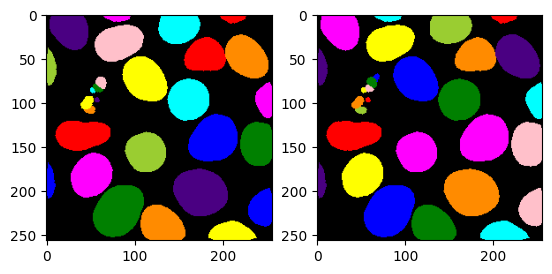

In [36]:
plt.subplot(1, 2, 1)
plt.imshow(color.label2rgb(labels_ref))
plt.subplot(1, 2, 2)
plt.imshow(color.label2rgb(labels.compute()))
plt.show()